In [21]:
# -*- coding: utf-8 -*-
"""
시도별 뉴스 언급량 vs 침수면적 스크립트 (침수면적 기준 분석)
"""

import re
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr

# --------------------------------------------------
# 0. 경로 설정
# --------------------------------------------------
ROOT = Path(r"C:/Users/user/Desktop/jupyter/침수 피해 데이터/분석 데이터")
NEWS_FILE   = ROOT / "NewsResult_20110101-20221231.xlsx"
ADMIN_FILE  = ROOT / "국토교통부_전국 법정동_20250415.csv"
SUBWAY_FILE = ROOT / "전국_지하철역_시도.csv"
FLOOD_FILE  = ROOT / "시도별_침수면적_통합_2011_2022.csv"
OUT_FILE    = Path(r"C:/Users/user/Desktop/jupyter/침수 피해 데이터/sido_mention_vs_area.csv")

# --------------------------------------------------
# 1. 시도 표준화
# --------------------------------------------------
SIDO_CANON = {
    '서울특별시':  ['서울특별시', '서울'],
    '부산광역시':  ['부산광역시', '부산'],
    '대구광역시':  ['대구광역시', '대구'],
    '인천광역시':  ['인천광역시', '인천'],
    '광주광역시':  ['광주광역시', '광주'],
    '대전광역시':  ['대전광역시', '대전'],
    '울산광역시':  ['울산광역시', '울산'],
    '세종특별자치시': ['세종특별자치시', '세종'],
    '경기도':      ['경기도', '경기'],
    '강원특별자치도': ['강원특별자치도', '강원'],
    '충청북도':    ['충청북도', '충북'],
    '충청남도':    ['충청남도', '충남'],
    '전라북도':    ['전라북도', '전북'],
    '전라남도':    ['전라남도', '전남'],
    '경상북도':    ['경상북도', '경북'],
    '경상남도':    ['경상남도', '경남'],
    '제주특별자치도': ['제주특별자치도', '제주'],
}

# --------------------------------------------------
# 2. 키워드 매핑 생성
# --------------------------------------------------
HANGUL_RE = re.compile(r'^[\uac00-\ud7a3]+$')
token2sidos = defaultdict(set)

def _add(tok, sido, *, allow_short=False):
    if not tok or len(tok) < 2 or not HANGUL_RE.fullmatch(tok): return
    token2sidos[tok.strip()].add(sido)

def add_with_variants(raw, sido):
    _add(raw, sido)
    trimmed = re.sub(r'(구|군|시|읍|면|동|리|역)$', '', raw)
    if len(trimmed) >= 3:
        _add(trimmed, sido)
    if not raw.endswith('역'):
        _add(f"{raw}역", sido)

admin = pd.read_csv(ADMIN_FILE, encoding='utf-8').fillna("")
for _, row in admin.iterrows():
    sido = row['시도명'].strip()
    for col in ('시군구명', '읍면동명', '리명'):
        add_with_variants(row[col], sido)

sub = pd.read_csv(SUBWAY_FILE, encoding='utf-8').fillna("")
for _, row in sub.iterrows():
    add_with_variants(row['역사명'], row['SIDO_NM'].strip())

for canon, aliases in SIDO_CANON.items():
    for a in aliases:
        _add(a, canon, allow_short=True)

clean_token2sido = {tok: list(sidos)[0] for tok, sidos in token2sidos.items() if len(sidos) == 1}
token_patterns = [(tok, re.compile(fr'{re.escape(tok)}')) for tok in sorted(clean_token2sido, key=len, reverse=True)]

# --------------------------------------------------
# 3. 뉴스 분석
# --------------------------------------------------
news = pd.read_excel(NEWS_FILE)
body_col = '위치' if '위치' in news.columns else news.columns[0]

sido_counts = defaultdict(int)
for text in tqdm(news[body_col].fillna(""), desc="📰 본문 분석"):
    if not isinstance(text, str): continue
    for tok, pat in token_patterns:
        hits = len(pat.findall(text))
        if hits:
            sido = clean_token2sido[tok]
            sido_counts[sido] += hits

mention_df = pd.Series(sido_counts, name='언급횟수').reset_index()
mention_df.columns = ['시도명', '언급횟수']

# --------------------------------------------------
# 4. 침수 데이터 로딩 (침수면적 기준)
# --------------------------------------------------
flood_df = pd.read_csv(FLOOD_FILE, encoding='utf-8').fillna("")
flood_df = flood_df.rename(columns={
    'SIDO_NAME': '시도명',
    '침수흔적_건수': '침수흔적수',
    '침수면적_합계': '침수면적'
})

if '시도명' not in flood_df.columns:
    flood_df['시도명'] = flood_df['시군구명'].str.extract(r'^([^\s]+)')

flood_sido_df = (
    flood_df.groupby('시도명')['침수면적']
    .sum().reset_index()
)

flood_sido_df = flood_sido_df[flood_sido_df['침수면적'] > 0]

# --------------------------------------------------
# 5. 병합 및 분석
# --------------------------------------------------
merged = pd.merge(mention_df, flood_sido_df, on='시도명', how='inner')
merged['침수대비기사비율'] = merged['언급횟수'] / merged['침수면적']

# --------------------------------------------------
# 6. 상관 분석 및 저장
# --------------------------------------------------
corr, pval = spearmanr(merged['침수면적'], merged['언급횟수'])

print("\n 침수면적 vs 기사 언급량")
print(f"Spearman 상관계수: {corr:.3f}, p-value: {pval:.4f}")

# 침수는 많은데 기사는 적은 시도
print("\n 침수는 많은데 보도가 적은 시도 TOP 5:")
print(merged.sort_values('침수대비기사비율').head(5)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

# 침수는 적은데 기사는 많은 시도
print("\n 침수에 비해 보도가 많은 시도 TOP 5:")
print(merged.sort_values('침수대비기사비율', ascending=False).head(5)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

# 전체 출력
print("\n 전체 정렬된 도별 데이터:")
print(merged.sort_values('침수대비기사비율', ascending=False).reset_index(drop=True)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

# 결과 저장
merged.to_csv(OUT_FILE, index=False, encoding='utf-8-sig')
print(f"\n 결과 저장 완료 → {OUT_FILE}")

C:\Users\user\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
📰 본문 분석: 100%|██████████| 14214/14214 [00:37<00:00, 377.09it/s]


 침수면적 vs 기사 언급량
Spearman 상관계수: 0.364, p-value: 0.1819

 침수는 많은데 보도가 적은 시도 TOP 5:
     시도명  언급횟수          침수면적      침수대비기사비율
14   강원도     9  5.614059e+07  1.603118e-07
13   제주도    84  4.930215e+07  1.703780e-06
6   경상남도  7355  3.220965e+09  2.283477e-06
9   전라남도  6609  8.782575e+08  7.525128e-06
12  전라북도  1650  6.548091e+07  2.519818e-05

 침수에 비해 보도가 많은 시도 TOP 5:
      시도명   언급횟수          침수면적  침수대비기사비율
10  인천광역시   1985  1.392355e+05  0.014256
0   서울특별시  11309  5.593913e+06  0.002022
7   대전광역시   1651  4.173725e+06  0.000396
4   부산광역시   9219  6.136868e+07  0.000150
8    충청남도   2258  2.398596e+07  0.000094

 전체 정렬된 도별 데이터:
      시도명   언급횟수          침수면적      침수대비기사비율
0   인천광역시   1985  1.392355e+05  1.425642e-02
1   서울특별시  11309  5.593913e+06  2.021662e-03
2   대전광역시   1651  4.173725e+06  3.955699e-04
3   부산광역시   9219  6.136868e+07  1.502232e-04
4    충청남도   2258  2.398596e+07  9.413840e-05
5   울산광역시   2638  4.721854e+07  5.586789e-05
6    경상북도   7626  1.543771e+08  4.939852e-05
7   광주광역시  

In [23]:
# --------------------------------------------------
# 7. 침수면적 순위 및 보도량 순위 출력
# --------------------------------------------------
# 전체 침수면적 순위 출력
print("\n 전체 침수면적 순위:")
print(merged.sort_values('침수면적', ascending=False)[['시도명', '침수면적']].reset_index(drop=True))

# 전체 보도량 순위 출력
print("\n 전체 보도량 순위:")
print(merged.sort_values('언급횟수', ascending=False)[['시도명', '언급횟수']].reset_index(drop=True))


 전체 침수면적 순위:
      시도명          침수면적
0    경상남도  3.220965e+09
1    전라남도  8.782575e+08
2     경기도  2.787870e+08
3    경상북도  1.543771e+08
4    충청북도  8.057612e+07
5    전라북도  6.548091e+07
6   부산광역시  6.136868e+07
7     강원도  5.614059e+07
8   광주광역시  5.375093e+07
9     제주도  4.930215e+07
10  울산광역시  4.721854e+07
11   충청남도  2.398596e+07
12  서울특별시  5.593913e+06
13  대전광역시  4.173725e+06
14  인천광역시  1.392355e+05

 전체 보도량 순위:
      시도명   언급횟수
0   서울특별시  11309
1     경기도  10112
2   부산광역시   9219
3    경상북도   7626
4    경상남도   7355
5    전라남도   6609
6   울산광역시   2638
7    충청북도   2627
8   광주광역시   2497
9    충청남도   2258
10  인천광역시   1985
11  대전광역시   1651
12   전라북도   1650
13    제주도     84
14    강원도      9


 침수면적 정규성 검정: W=0.435, p-value=0.00000
 언급횟수 정규성 검정: W=0.876, p-value=0.04156


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


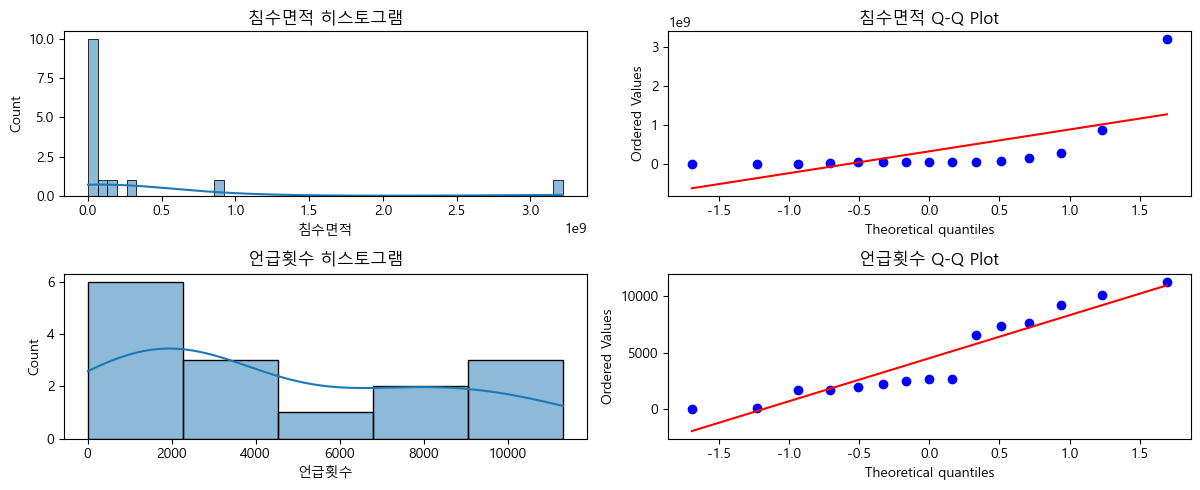

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot
import matplotlib as mpl

# 한글 폰트 설정
mpl.rc('font', family='Malgun Gothic')

# 마이너스 깨짐 방지
mpl.rc('axes', unicode_minus=False)

# 1. 정규성 검정
stat1, p1 = shapiro(merged['침수면적'])
stat2, p2 = shapiro(merged['언급횟수'])

print(f" 침수면적 정규성 검정: W={stat1:.3f}, p-value={p1:.5f}")
print(f" 언급횟수 정규성 검정: W={stat2:.3f}, p-value={p2:.5f}")

# 2. 시각화: 히스토그램 + Q-Q plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
sns.histplot(merged['침수면적'], kde=True)
plt.title("침수면적 히스토그램")

plt.subplot(2, 2, 2)
probplot(merged['침수면적'], dist="norm", plot=plt)
plt.title("침수면적 Q-Q Plot")

plt.subplot(2, 2, 3)
sns.histplot(merged['언급횟수'], kde=True)
plt.title("언급횟수 히스토그램")

plt.subplot(2, 2, 4)
probplot(merged['언급횟수'], dist="norm", plot=plt)
plt.title("언급횟수 Q-Q Plot")

plt.tight_layout()
plt.show()

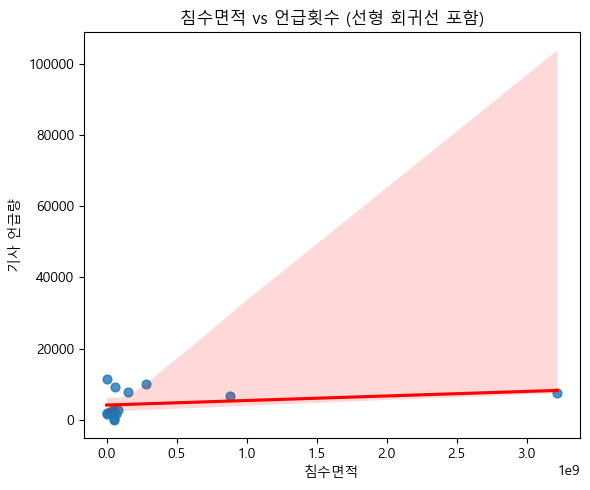

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.regplot(x='침수면적', y='언급횟수', data=merged, scatter_kws={'s': 40}, line_kws={'color': 'red'})
plt.title("침수면적 vs 언급횟수 (선형 회귀선 포함)")
plt.xlabel("침수면적")
plt.ylabel("기사 언급량")
plt.tight_layout()
plt.show()

In [29]:
# --------------------------------------------------
# 1. 배수펌프장 데이터 불러오기
# --------------------------------------------------
PUMP_DF = ROOT / "전국배수펌프장표준데이터.csv"
pump_df = pd.read_csv(PUMP_DF, encoding='cp949')

# --------------------------------------------------
# 2. 시도별 배수펌프장 수 카운트
# --------------------------------------------------
pump_count = pump_df['시도명'].value_counts().reset_index()
pump_count.columns = ['시도명', '배수펌프장수']

# --------------------------------------------------
# 3. 앞서 생성된 merged 데이터프레임과 병합
# --------------------------------------------------
merged_pump = pd.merge(merged, pump_count, on='시도명', how='left')

# --------------------------------------------------
# 4. NaN은 0으로 처리 (배수펌프장이 없는 경우)
# --------------------------------------------------
merged_pump['배수펌프장수'] = merged_pump['배수펌프장수'].fillna(0)

# --------------------------------------------------
# 5. 침수면적 대비 배수펌프장 수, 침수면적 대비 기사 언급 비율 계산
# --------------------------------------------------
merged_pump['침수면적대비펌프장수'] = merged_pump['배수펌프장수'] / merged_pump['침수면적']
merged_pump['침수면적대비기사비율'] = merged_pump['언급횟수'] / merged_pump['침수면적']

# --------------------------------------------------
# 6. 상관관계 분석
# --------------------------------------------------
from scipy.stats import spearmanr
corr_pump_ratio, pval_pump_ratio = spearmanr(
    merged_pump['침수면적대비펌프장수'], 
    merged_pump['침수면적대비기사비율']
)

# --------------------------------------------------
# 7. 결과 출력
# --------------------------------------------------
print(f"\n 침수면적 대비 배수펌프장 수 vs 침수면적 대비 기사 비율")
print(f"Spearman 상관계수: {corr_pump_ratio:.3f}, p-value: {pval_pump_ratio:.4f}")


 침수면적 대비 배수펌프장 수 vs 침수면적 대비 기사 비율
Spearman 상관계수: 0.764, p-value: 0.0009
